In this notebook, I aim to answer:

- Data exploration – What are the most interesting features of the data set? What have you considered and why have you made the decisions you have done?
- Modelling – What process did you follow when modelling sales?  How have you designed your model and what did you account for?
- Conclusions – What are your main findings? How might you use those insights, or your model, to improve Hastings’ pricing? What else would it have been useful to know?

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
df=pd.read_csv('data.csv')
df.head(3)

# Create Training / Test and Holdout

In [25]:
# define training / validation 
training_df, validation_df, response_training_df, response_validation_df = train_test_split(df.drop(['Sale'], axis=1), df['Sale'], test_size=0.2, random_state=1)

In [39]:
# Null Accuracy Score in dataset, training and test
lst = [0] * len(df['Sale'])
print('Dataset Null Accuracy Score:', accuracy_score(df['Sale'],pd.Series(lst)))

lst = [0] * len(response_training_df)
print(f'Training Null Accuracy Score: {accuracy_score(response_training_df, pd.Series(lst))}')

lst = [0] * len(response_validation_df)
print(f'Test Null Accuracy Score: {accuracy_score(response_validation_df, pd.Series(lst))}')

Dataset Null Accuracy Score: 0.30202
Training Null Accuracy Score: 0.299975
Test Null Accuracy Score: 0.3102


# EDA

In [4]:
# add id col
df['row_num'] = np.arange(len(df))
df['Exposure'] = 1

In [5]:
# duplicates
print(df.shape)
print(df.drop_duplicates().shape)

(50000, 12)
(50000, 12)


In [6]:
# missing
df['Marital_Status']=df['Marital_Status'].fillna('MI')

In [7]:
# Feature Engineering
df['Year']=pd.to_datetime(df['Date']).dt.year
df['Month']=pd.to_datetime(df['Date']).dt.month_name()
df['Day']=pd.to_datetime(df['Date']).dt.day_name()
df['Year_Month']=pd.to_datetime(df['Date']).dt.year.astype(str)+pd.to_datetime(df['Date']).dt.month.astype(str).str.zfill(2)

In [8]:
# categoric cols
cat_cols=['Day',
'Marital_Status']

# one hot encoding
for i in cat_cols:
    for j in df[i].unique():
        df[i+'_'+j]=np.where(df[i]==j,1,0)

# Correlated Cols

In [10]:
df.head(3)

,Driver_Age,Vehicle_Value,Tax,Price,Vehicle_Mileage,Credit_Score,Licence_Length_Years,Date,Marital_Status,Sale,...,Day_Saturday,Day_Friday,Day_Thursday,Day_Monday,Day_Tuesday,Day_Wednesday,Marital_Status_M,Marital_Status_S,Marital_Status_D,Marital_Status_MI
0,48.0,7000.0,41.961971,419.619709,7000.0,366.105677,8.711803,29/05/2016,M,0,...,0,0,0,0,0,0,1,0,0,0
1,32.0,8000.0,53.448931,534.489312,6000.0,306.560408,8.754815,03/07/2015,S,0,...,1,0,0,0,0,0,0,1,0,0
2,32.0,7000.0,48.042838,480.428376,6000.0,430.070380,6.942515,04/10/2015,M,0,...,0,1,0,0,0,0,1,0,0,0


# Visualisation

In [11]:
def plot_one_ways(i, diff_band, exposure, obs, target_name, width=0.5):
    
    """
    function to create one way plots
    - diff_band: the x co-ordinates for plots
    - exposure: number of rows per diff_band grouping
    - width: width of columns predefined as 0.5
    - target_name: response to plot as line
    """
    
    plt.bar(diff_band, exposure, width, color='gold', label='Diff', edgecolor='k')
    plt.xticks(rotation=90)
    plt.ylim(0, max(exposure)*3)
    plt.ylabel('Exposure')
    plt.xlabel(f'{i}')
    plt.title(f'One Way Plot of {i}')

    # Line plot
    axes2 = plt.twinx()
    axes2.plot(diff_band, obs, color='fuchsia', marker="s", markeredgecolor='black', label='Actual')
    axes2.set_ylabel(target_name)

    # legend and settings
    plt.legend(loc="upper left")

    plt.show()

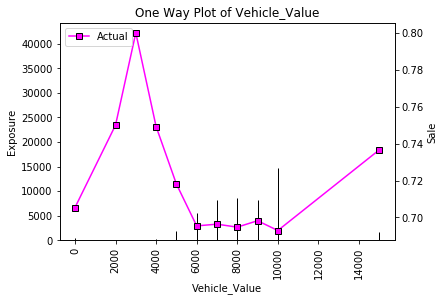

In [12]:
i='Vehicle_Value'
target_name='Sale'

# Plot Original
df[i]=df[i].fillna(-1)
exposure=df.groupby(i)['Exposure'].sum()
obs=df.groupby(i)[target_name].mean()
diff_band=sorted(set(df[i]))
plot_one_ways(i, diff_band, exposure, obs, target_name)

# Conclusions

In [13]:
# what is missing?
# vehicle value at new / vehicle value when bought
# claims history
# occupation
# geographical factors
# exposure period
# telematics
# excess
# gender
# id column / identifier
# time of quote
# difference in live data vs modelled data
# selection biases